In [38]:
# Import needed libraries
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import load_model
import random
import pickle

In [14]:
data_model = pd.read_csv("data_model.csv")

In [15]:
data_model.head()

,Unnamed: 0,ColorSpecification1,Color1,Fabric1,Category1,AggregatedFamily1,Family1,Type1,ColorSpecification2,Color2,Fabric2,Category2,AggregatedFamily2,Family2,Type2,Match
0,29544,NEGRO,GREY,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Accessories,Footwear,Shoes,BEIGE,WHITE,P-PLANA,Bottoms,Trousers & leggings,Trousers,Trousers,1
1,191331,CAMEL,WHITE,P-PLANA,Outerwear,Jackets and Blazers,Blazers,Blazer,KHAKI,BROWN,P-PLANA,Outerwear,Coats and Parkas,Puffer coats,Puffer coat,0
2,73552,TEJANO OSCURO,BLUE,J-JEANS,Bottoms,Jeans,Jeans,Jeans,ORO,WHITE,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Accessories,Jewellery,Earrings,1
3,174351,NEGRO,GREY,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Accessories,Bags,Handbag,PLATA,GREY,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Accessories,Jewellery,Ring,0
4,144485,NEGRO,GREY,T-TRICOT,Tops,Sweaters and Cardigans,Sweater,Sweater,NEGRO,GREY,C-COMPLEMENTOS,"Accesories, Swim and Intimate",Accessories,Footwear,Shoes,0


In [16]:
# One-hot encode the 'Category' column
data_model_ohe = pd.get_dummies(data_model, columns=['ColorSpecification1', 'Color1', 'Fabric1', 'Category1', 'AggregatedFamily1', 'Family1', 'Type1', 'ColorSpecification2', 'Color2', 'Fabric2', 'Category2', 'AggregatedFamily2', 'Family2', 'Type2'], prefix=['ColorSpecification1', 'Color1', 'Fabric1', 'Category1', 'AggregatedFamily1', 'Family1', 'Type1', 'ColorSpecification2', 'Color2', 'Fabric2', 'Category2', 'AggregatedFamily2', 'Family2', 'Type2'])
# Create the training dataset (It is going to be th full dataset)
X_train = data_model_ohe.drop(['Unnamed: 0', 'Match'], axis = 1)
Y_train = data_model_ohe['Match']

print(X_train.shape, Y_train.shape)

(196638, 522) (196638,)


In [28]:
with open('X_train_columns.pkl', 'wb') as f:
    pickle.dump(X_train.columns, f)

In [71]:
# with tensorflow, train a neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(522,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Change the loss function
              metrics=['accuracy'])

# Identify boolean columns
bool_columns = X_train.select_dtypes(include='bool').columns
# Convert False to 0 and True to 1 for boolean columns
X_train[bool_columns] = X_train[bool_columns].astype(int)

model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
6145/6145 [==============================] - 29s 5ms/step - loss: 0.6568 - accuracy: 0.6000
Epoch 2/10
6145/6145 [==============================] - 29s 5ms/step - loss: 0.6298 - accuracy: 0.6358
Epoch 3/10
6145/6145 [==============================] - 28s 5ms/step - loss: 0.6206 - accuracy: 0.6451
Epoch 4/10
6145/6145 [==============================] - 28s 5ms/step - loss: 0.6138 - accuracy: 0.6528
Epoch 5/10
6145/6145 [==============================] - 28s 5ms/step - loss: 0.6086 - accuracy: 0.6582
Epoch 6/10
6145/6145 [==============================] - 30s 5ms/step - loss: 0.6039 - accuracy: 0.6621
Epoch 7/10
6145/6145 [==============================] - 28s 5ms/step - loss: 0.6009 - accuracy: 0.6643
Epoch 8/10
6145/6145 [==============================] - 28s 5ms/step - loss: 0.5979 - accuracy: 0.6686
Epoch 9/10
6145/6145 [==============================] - 28s 5ms/step - loss: 0.5954 - accuracy: 0.6696
Epoch 10/10
6145/6145 [==============================] - 28s 4ms/step - l

In [157]:
# save the trained model
model.save("trained_model.h5")

In [9]:
def load_trained_model():
    # Replace 'trained_model.h5' with the actual path to your saved model
    model_path = './datathon/trained_model.h5'
    loaded_model = load_model(model_path)
    return loaded_model

model = load_trained_model()

Metal device set to: Apple M2


In [12]:
products = pd.read_csv("./datathon/dataset/product_data.csv")

In [40]:
### Let's make a prediction!
def make_prediction(prod_test):
    des_product_category = ['Bottoms', 'Dresses, jumpsuits and Complete set', 'Tops','Accesories, Swim and Intimate', 'Outerwear']

    # Matrix with accepted outfit configurations per given seed product
    m_des_product_category = [ [0, 0, 1, 1, 1],
          [0, 0, 0, 1, 1],
          [1, 0, 0, 1, 1],
          [1, 0, 1, 0, 1],
          [1, 0, 1, 1, 0],
        ]

    # Only able to select or dress or bottoms + tops. Choose this option randomly
    if random.choice([True, False]):
        m_des_product_category[3][0:3] = [0,1,0]
    if random.choice([True, False]):
        m_des_product_category[4][0:3] = [0,1,0]

    # Dicts to check dimensions of matrix and data in the dataset
    ind2 = {value: index for index, value in enumerate(des_product_category)}
    ind3 = {index: value for index, value in enumerate(des_product_category)}

    # Colors for the data model that will predict matchings
    columns = ['ColorSpecification1', 'Color1', 'Fabric1', 'Category1', 'AggregatedFamily1', 'Family1', 'Type1', 'ColorSpecification2', 'Color2', 'Fabric2', 'Category2', 'AggregatedFamily2', 'Family2', 'Type2']
    data_model = pd.DataFrame(columns=columns)

    # Colors to get info from the products dataset
    cols_clean_data = ['des_color_specification_esp', 'des_agrup_color_eng', 'des_fabric', 'des_product_category', 'des_product_aggregated_family', 'des_product_family', 'des_product_type']

    # Merge two rows to return the row that fits the predicting dataset
    def compute_row(prod1, prod2):
        prod1_list = []
        prod2_list = []
        for col in cols_clean_data:
            prod1_list.append(prod1[col])
            prod2_list.append(prod2[col])

        return prod1_list + prod2_list  


    # Make outfit prediction
    outfit_prediction = []
    for index, col in enumerate(m_des_product_category[ind2[prod_test['des_product_category']]]): # recorre los 1s de la fila
        if col == 1: # accedim a la posició de la matriu
            X_test = pd.DataFrame(columns = columns) # data frame de files prod_test amb totes els 'tops', per ex
            X_test_index = []
            for index, prod in products[products['des_product_category'] == ind3[index]].iterrows():
                X_test.loc[len(X_test)] = compute_row(prod_test, prod)
                X_test_index.append(prod['des_filename'])

            X_test = pd.get_dummies(X_test, columns=['ColorSpecification1', 'Color1', 'Fabric1', 'Category1', 'AggregatedFamily1', 'Family1', 'Type1', 'ColorSpecification2', 'Color2', 'Fabric2', 'Category2', 'AggregatedFamily2', 'Family2', 'Type2'], prefix=['ColorSpecification1', 'Color1', 'Fabric1', 'Category1', 'AggregatedFamily1', 'Family1', 'Type1', 'ColorSpecification2', 'Color2', 'Fabric2', 'Category2', 'AggregatedFamily2', 'Family2', 'Type2'])
            missing_columns = set(X_train.columns) - set(X_test.columns)

            # Add missing columns to X_test
            for col in missing_columns:
                X_test[col] = 0

            # Reorder columns in X_test
            X_test = X_test[X_train.columns]
            # Separate features and target variable in X_test
            #X_test = X_test.drop(['Match'], axis=1)
            # Identify boolean columns
            bool_columns_test = X_test.select_dtypes(include='bool').columns
            # Convert False to 0 and True to 1 for boolean columns
            X_test[bool_columns_test] = X_test[bool_columns_test].astype(int)

            prediction = model.predict(X_test)
            print(prediction)

            result = [(X_test_index[i], prediction[i]) for i in range(len(prediction))]
            sorted_result = sorted(result, key=lambda x: x[1], reverse=True)

            outfit_prediction.append(sorted_result[0])
    return outfit_prediction



In [44]:
outfit_prediction = make_prediction(prod_test=products.iloc[0]);
outfit_prediction

87/87 [==============================] - 0s 1ms/step


/var/folders/lt/0rnvcllx1gg1rl6q7q4n7p440000gn/T/ipykernel_45812/4278142493.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
/var/folders/lt/0rnvcllx1gg1rl6q7q4n7p440000gn/T/ipykernel_45812/4278142493.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
/var/folders/lt/0rnvcllx1gg1rl6q7q4n7p440000gn/T/ipykernel_45812/4278142493.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

[[0.5598826 ]
 [0.41245914]
 [0.66902256]
 ...
 [0.6589871 ]
 [0.45966133]
 [0.42050883]]
83/83 [==============================] - 0s 1ms/step


/var/folders/lt/0rnvcllx1gg1rl6q7q4n7p440000gn/T/ipykernel_45812/4278142493.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
/var/folders/lt/0rnvcllx1gg1rl6q7q4n7p440000gn/T/ipykernel_45812/4278142493.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
/var/folders/lt/0rnvcllx1gg1rl6q7q4n7p440000gn/T/ipykernel_45812/4278142493.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

[[0.6890799 ]
 [0.5997873 ]
 [0.4456674 ]
 ...
 [0.49468073]
 [0.7244419 ]
 [0.62266797]]
23/23 [==============================] - 0s 1ms/step
[[0.3209198 ]
 [0.27274382]
 [0.44143325]
 [0.24105318]
 [0.43629795]
 [0.2887494 ]
 [0.51568997]
 [0.6787355 ]
 [0.52976584]
 [0.5663173 ]
 [0.51568997]
 [0.2214494 ]
 [0.44143325]
 [0.4282755 ]
 [0.5265861 ]
 [0.3604277 ]
 [0.2630725 ]
 [0.22895348]
 [0.45107475]
 [0.6285705 ]
 [0.71001416]
 [0.16891569]
 [0.22023642]
 [0.52976584]
 [0.58634835]
 [0.41235736]
 [0.6069179 ]
 [0.5563952 ]
 [0.2867212 ]
 [0.43629795]
 [0.55712867]
 [0.30088916]
 [0.5524398 ]
 [0.32580388]
 [0.7150455 ]
 [0.5121351 ]
 [0.26773444]
 [0.54466736]
 [0.61194456]
 [0.533628  ]
 [0.5121351 ]
 [0.61207455]
 [0.48216286]
 [0.30727726]
 [0.43629795]
 [0.531186  ]
 [0.41406387]
 [0.21008857]
 [0.2887494 ]
 [0.45378295]
 [0.43629795]
 [0.26994863]
 [0.5921688 ]
 [0.533628  ]
 [0.38232887]
 [0.53205407]
 [0.22895348]
 [0.32382676]
 [0.44143325]
 [0.74811345]
 [0.533628  ]
 [0

/var/folders/lt/0rnvcllx1gg1rl6q7q4n7p440000gn/T/ipykernel_45812/4278142493.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
/var/folders/lt/0rnvcllx1gg1rl6q7q4n7p440000gn/T/ipykernel_45812/4278142493.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
/var/folders/lt/0rnvcllx1gg1rl6q7q4n7p440000gn/T/ipykernel_45812/4278142493.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

[('datathon/images/2019_53061093_41.jpg', array([0.9017301], dtype=float32)),
 ('datathon/images/2019_43085809_28.jpg', array([0.912039], dtype=float32)),
 ('datathon/images/2019_41089072_05.jpg', array([0.8329643], dtype=float32))]

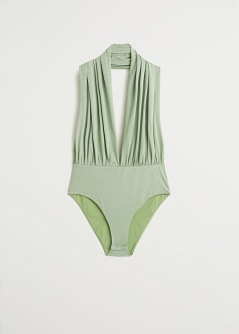

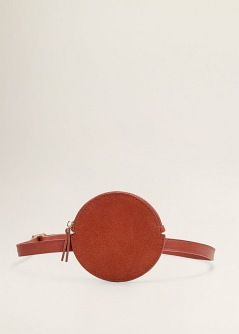

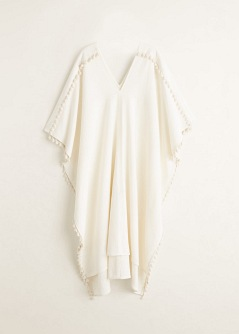

In [45]:
def visualizeOutfit(list_products: list) -> None:
    for prod in list_products:
#        product = Image.open('.' + prod['des_filename'])
        display(Image.open(prod[0]))
        #display(product)

visualizeOutfit(outfit_prediction)